# Analyzing precip and temperature data

## Learning objectives

1. Document your project data by capturing important information
   as metadata in a json file

1. Use the groupby method for a pandas dataframe to group observations
   by season

1. Find the probability density function (histogram) of temperature and
   precipitation data and determine possible statistical models (normal distribution,
   exponential distribution) that best describe the variation in the data

1. Find best fit parameters for statistical models that describe the precipitation
   and temperature data, assuming that temperature and precipitation are
   independent of each other.

1. Use groupby to find the median temperature for each decade and each season
   and determine whether the seasonal temperatures have increased at YVR
   since the 1930's

## Introduction

We have about 30,000 days worth of YVR precipitation and temperature
data generated by the 10-pandas1, 10-pandas2, and 10-pandas3 notebooks, these
gave you a new csv file: data/processed/weather_YVR.csv.  We will use
that data set to estimate statistical distributions that could produce realistic
simulated rainfall and temperature inputs to a model.  It makes use of several
new python modules/methods:

1. The **context** module: We will write a new module called context.py that
   will be used to locate folders and libraries associated with a project, such as
   `weather_YVR.csv`.
1. **The json module**.  This reads and writes files written
   in "javascript object notation" i.e.
   [json](https://en.wikipedia.org/wiki/JSON).  We will use it to
   save "metadata" or data about our data.

1. **pandas.DataFrame.groupby**
   We will use groupby to split the dataframe into 4 seasons, each corresponding
   to 3 months of the year: winter (month initials djf), spring (mam),
   summer (jja), and fall (son).  This is the tip of the iceberg of what
   you can do with pandas split/apply/combine functions.  For more examples
   see [the Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb)

1. The [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) module.  As you will see
   below, the temperature data is best fit with a a Gaussian (normal) distribution
   using the norm.fit:
   - [scipy.stats.norm.fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm)

   Precipitation, on the other hand, follows an exponential distribution, which
   can be fit with:
   - [scipy.stats.expon.fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon)

In [1]:
import json

import context
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import pprint
import numpy as np

in context.py, setting root_dir to /Users/phil/repos
******************************
context imported. Front of path:
/Users/phil/repos
/Users/phil/repos/pandas_yvr
******************************



## The context module (repeated from 10-pandas1)

As our project grows more complicated, it's good to have a central
module that keeps track of important files and sets your scripts
up so that they can import functions and classes from you modules.
If you were planning to distribute your project using conda, then
you would need to write an installation script, which is a fair
amount of work.   At this stage, it's easier and more flexible to
store that information in a file that travels along with your notebook.
By convention, this file is called:
[context.py](https://github.com/phaustin/eosc213_students/blob/master/notebooks/pandas/context.py)

Clicking on that link shows you the source -- the code is executed when
you do `import context` and does the following:

1. Defines Path objects that give the location of the raw and processed data folders

1. Puts the notebooks/pandas folder on python's list of places to look for
   library modules (sys.path).  We will use this when we start extracting
   code from notebooks into libraries

In [2]:
#
# Here is the path to the processed csv file
#
print(context.processed_dir)

/Users/phil/repos/pandas_yvr/data/processed


## Reading the processed data

The next cell uses ["globbing"](https://en.wikipedia.org/wiki/Glob_(programming)) to
find every csv file in all folders below `data/processed`.  (See
[this optional tutorial](https://realpython.com/python-pathlib/) for more information).

In [3]:
yvr_files = list(context.processed_dir.glob("**/*YVR*csv"))
print(f"yvr files: \n{pprint.pformat(yvr_files)}")

yvr files: 
[PosixPath('/Users/phil/repos/pandas_yvr/data/processed/weather_daily_YVR_1938-2019_all.csv'),
 PosixPath('/Users/phil/repos/pandas_yvr/data/processed/weather_YVR.csv')]


In [4]:
yvr_file = context.processed_dir / "weather_YVR.csv"

## Metadata is data about data

Since we care about this dataset, it's a good idea to save
details for future reference.  We can't put this kind of information
into a csv file, but there are many file formats that can store
this type of descriptive metadata -- one of the most popular is
[json](https://en.wikipedia.org/wiki/JSON).  In the next cell we
write the data into a nested dictionary called meta_dict, and
dump that information into a new json file called metadata.json

In [5]:
meta_data = dict()

file_info = dict()
file_info["written_by"] = "10-pandas3-process-daily-data.ipynb"
file_info["contact"] = "paustin@eoas.ubc.ca"
file_info[
    "description"
] = "EC canada YVR data downloaded by 10-pandas2-download-daily-data.ipynb"

meta_data["weather_daily_YVR_1938-2017_all.csv"] = file_info

file_info = dict()
file_info["written_by"] = "10-pandas3-process-daily-data.ipynb"
file_info["contact"] = "paustin@eoas.ubc.ca"
file_info[
    "description"
] = "Reduced YVR data subsetted by 10-pandas3-process-daily-data.ipynb"

meta_data["weather_YVR.csv"] = file_info

history_file = context.processed_dir / "history_metadata.json"
with open(history_file, "w") as f:
    json.dump(meta_data, f, indent=4)

Take a minute and look at history_metadata.json with jupyter to see how the metadata is written out.

## Read weather_YVR.csv into a dataframe

Here's the dataframe produced by 10-pandas3

In [6]:
yvr_df = pd.read_csv(yvr_file)
yvr_df.fillna(0.0, inplace=True)
print(f"there are {len(yvr_df)} days in the dataframe")
yvr_df.head()

there are 29920 days in the dataframe


,Date,Year,Month,Day,T_mean (C),T_high (C),T_low (C),Rain (mm),Snow (cm),Total Precip (mm)
0,-123.18,1938,1,1,4.4,9.4,-0.6,0.0,0.0,0.3
1,-123.18,1938,1,2,4.5,7.2,1.7,0.0,0.0,0.5
2,-123.18,1938,1,3,1.7,7.2,-3.9,0.0,0.0,0.0
3,-123.18,1938,1,4,2.2,7.2,-2.8,0.0,0.0,0.0
4,-123.18,1938,1,5,2.2,7.2,-2.8,0.0,0.0,0.0


## Use apply to tag the 29,190 days with their season

We know that the seasons are quite different, and if we are interested in
generating daily data we have to take that into account.  In the next cell
we set up a lookup table (dictionary) called season_table that maps the
month number to one of four seasons.  With this table we can write
a function called find_season that takes a row of the dataframe and
returns the season for that row

In [7]:
season_table = dict()
for i in range(12):
    m = i + 1
    if m in [12, 1, 2]:
        # winter
        season_table[m] = "djf"
    elif m in [3, 4, 5]:
        # spring
        season_table[m] = "mam"
    elif m in [6, 7, 8]:
        # summer
        season_table[m] = "jja"
    else:
        # fall
        season_table[m] = "son"


def find_season(row, season_table):
    month = row["Month"]
    return season_table[month]

### creating a new column with apply

We apply the find_season function to every row of the dataframe in the
cell below.  `axis=1` tells apply that we want to produce a new column
(axis 1), not a new row (axis 0).

In [8]:
season = yvr_df.apply(find_season, args=(season_table,), axis=1)

Now add that column to the dataframe

In [9]:
yvr_df["season"] = season
yvr_df.head()

,Date,Year,Month,Day,T_mean (C),T_high (C),T_low (C),Rain (mm),Snow (cm),Total Precip (mm),season
0,-123.18,1938,1,1,4.4,9.4,-0.6,0.0,0.0,0.3,djf
1,-123.18,1938,1,2,4.5,7.2,1.7,0.0,0.0,0.5,djf
2,-123.18,1938,1,3,1.7,7.2,-3.9,0.0,0.0,0.0,djf
3,-123.18,1938,1,4,2.2,7.2,-2.8,0.0,0.0,0.0,djf
4,-123.18,1938,1,5,2.2,7.2,-2.8,0.0,0.0,0.0,djf


## Grouping the data by season

The next cell uses the groupby method to sort all of the
rows into 4 seasons.  The resulting group object (`seasons`) has
4 dataframes inside it, keyed by the season marker djf, mam, etc.

In [10]:
seasons = yvr_df.groupby("season")
#dir(seasons)

### Use a dictionary comprehension put the dataframes into a dictionary

In the 10-pandas3 notebook we used a dictionary comprehension.  We'll use
one again below -- it will have 4 keys, one for each season, with each
key pointing to the seasonal dataframe.

In [11]:
season_dict = {key: value for key, value in seasons}
season_dict.keys()

dict_keys(['djf', 'jja', 'mam', 'son'])

Here is the fall dataframe

In [12]:
season_dict["son"].head()

,Date,Year,Month,Day,T_mean (C),T_high (C),T_low (C),Rain (mm),Snow (cm),Total Precip (mm),season
243,-123.18,1938,9,1,16.2,20.6,11.7,1.3,0.0,1.3,son
244,-123.18,1938,9,2,15.3,18.9,11.7,2.3,0.0,2.3,son
245,-123.18,1938,9,3,15.0,19.4,10.6,0.0,0.0,0.0,son
246,-123.18,1938,9,4,14.8,17.8,11.7,3.3,0.0,3.3,son
247,-123.18,1938,9,5,15.6,19.4,11.7,1.3,0.0,1.3,son


## Fitting the distributions

### Daily average temperature

The next cell shows histograms temperature for each of the seasons.  We use
[scipy.stats.norm.fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm) to
find the mean and standard deviation (called the `loc` and `scale` here) of the data
and then shows that fitted distribution as a red line.  Specifically, for temperatures x the red
line is a plot of:

\begin{align*}
f(y) &= \frac{\exp(-y^2/2)}{\sqrt{2\pi}} \\
y &= (x - loc) / scale
\end{align*}

The four plots show that a normal distribution give as pretty good representation of each of the seasons.

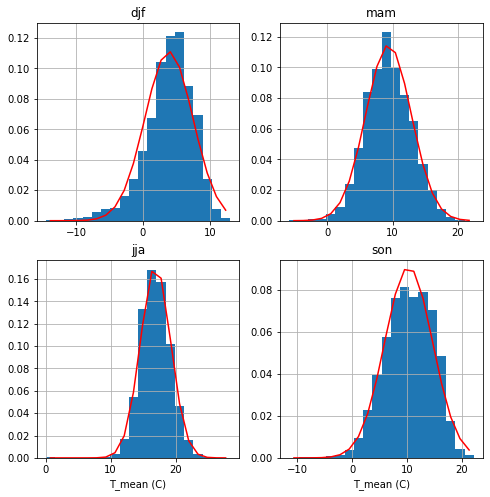

In [13]:
key_list = ["djf", "mam", "jja", "son"]
df_list = [season_dict[key] for key in key_list]
fig, ax_array = plt.subplots(2, 2, figsize=(8, 8))
ax_list = ax_array.flatten()
var = "T_mean (C)"
temp_params = dict()
for index, key in enumerate(key_list):
    the_ax = ax_list[index]
    the_df = df_list[index]
    the_temps = the_df[var]
    mu, sigma = st.norm.fit(the_temps)
    temp_params[key] = (mu, sigma)
    vals, bins, patches = the_ax.hist(var, bins=20, data=the_df, density=True)
    bin_centers = (bins[1:] + bins[0:-1]) / 2.0
    the_ax.plot(bin_centers, st.norm.pdf(bin_centers, mu, sigma), "r-")
    the_ax.grid(True)
    the_ax.set(title=key)
    if index > 1:
        the_ax.set(xlabel=var)

### Daily average total precipitation

Precipitation data is a different story.  Because negative precipitation
is impossible, there is no way a normal distribution is going to work
to represent the variablity.  Instead we use
[scipy.stats.expon.fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon) to fit an exponential distribution.

\begin{align*}
f(y) &= \exp(-y)\\
y &= (x - loc) / scale
\end{align*}


where `loc` is the minimum of the data and `scale` is the distance
between the minimum and the mean.

The fits are not quite as good -- but do capture the one-sided nature
of the variability.

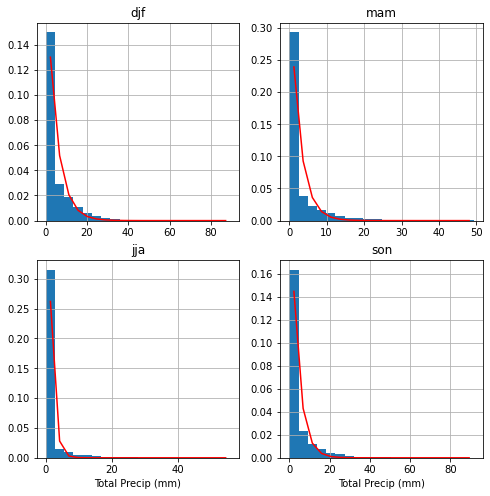

In [14]:
fig, ax_array = plt.subplots(2, 2, figsize=(8, 8))
ax_list = ax_array.flatten()
var = "Total Precip (mm)"
precip_params = dict()
for index, key in enumerate(key_list):
    the_ax = ax_list[index]
    the_df = df_list[index]
    the_precip = the_df[var]
    loc, scale = st.expon.fit(the_precip)
    precip_params[key] = (loc, scale)
    vals, bins, patches = the_ax.hist(var, bins=20, data=the_df, density=True)
    bin_centers = (bins[1:] + bins[0:-1]) / 2.0
    the_ax.plot(bin_centers, st.expon.pdf(bin_centers, loc, scale), "r-")
    the_ax.grid(True)
    the_ax.set(title=key)
    if index > 1:
        the_ax.set(xlabel=var)

## Saving the fit parameters

We have two new dictionaries: `temp_params` and `precip_params` that
we should save for the future.

In [15]:
data_dict = dict()
data_dict[
    "metadata"
] = """
          loc,scale tuples for daily average temperature (deg C)
          and precipitation (mm) produced by 11-pandas4 for YVR
          """
data_dict["temp"] = temp_params
data_dict["precip"] = precip_params
fit_file = context.processed_dir / "fit_metadata.json"
with open(fit_file, "w") as f:
    json.dump(data_dict, f, indent=4)

In [16]:
def find_decade(row):
    """
    given a row from an Environment Canada dataframe
    return the first 3 digits of the year as an integer
    
    i.e. turn "2010" into the number 201
    """
    year_string=f"{row['Year']:4d}"
    return int(year_string[:3])


def decadal_groups(season_df):
    """
    given a season dataframe produced by groupby('season'), add
    a column called 'decade' with the 3 digit decade
    and return a groupby dictionary of decade dataframes for that
    season with the decade as key
    """
    #
    # add the decade column to the dataframe using apply
    #
    decade=season_df.apply(find_decade,axis=1)
    season_df['decade']=decade
    #
    # do the groupby and turn into a dictionary
    #
    decade_groups=season_df.groupby('decade')
    decade_dict={key:value for key,value in decade_groups}
    return decade_dict

def median_temps(decade_dict):
    """
    given a decade_dict produced by the decadal_temp function
    return a 2-column numpy array.  The first column should be the
    integer decade (193,194,etc.) and the second column should be
    the median temperature for that decade
    """
    values=list()
    for the_decade,the_df in decade_dict.items():
        T_median=the_df['T_mean (C)'].median()
        values.append((the_decade,T_median))
    result=np.array(values)
    return result

season_temps=dict()
for season_key,season_df in season_dict.items():
    decade_dict=decadal_groups(season_df)
    temp_array=median_temps(decade_dict)
    season_temps[season_key]=temp_array   

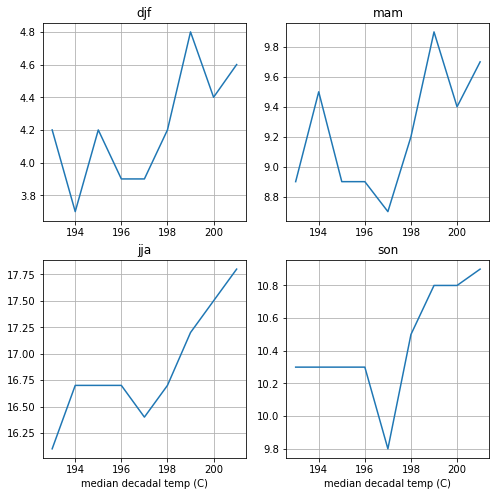

In [17]:
fig, ax_array = plt.subplots(2, 2, figsize=(8, 8))
ax_list = ax_array.flatten()
for index,key in enumerate(key_list):
    temps=season_temps[key]
    the_ax=ax_list[index]
    the_ax.plot(temps[:,0],temps[:,1])
    the_ax.grid(True)
    the_ax.set(title=key)
    if index > 1:
        the_ax.set(xlabel='median decadal temp (C)')